# Sentiment Analysis: VADER vs. RoBERTa
## Introduction
This project compares two sentiment analysis approaches: 
- **VADER (Valence Aware Dictionary and sEntiment Reasoner)**, a rule-based model designed for social media sentiment.
- **RoBERTa (Robustly Optimized BERT)**, a transformer-based model fine-tuned for sentiment classification.

The goal is to analyze book reviews (from `Books_rating.csv`) and compare:
1. Accuracy of sentiment predictions
2. Differences in sentiment scoring between the two models
3. Performance and computational efficiency

## Importing Libraries and Pytorch Initialization

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import time

In [2]:
import torch
print(torch.cuda.is_available())
device = torch.device("cuda")
print(device)

True
cuda


In [3]:
import torch.nn.functional as F

In [4]:
plt.style.use('bmh')

## Reading and Cleaning of Data

In [5]:
df = pd.read_csv('Books_rating.csv')

In [6]:
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB


In [8]:
df.describe()

,Price,review/score,review/time
count,481171.000000,3.000000e+06,3.000000e+06
mean,21.762656,4.215289e+00,1.132307e+09
std,26.206541,1.203054e+00,1.493202e+08
min,1.000000,1.000000e+00,-1.000000e+00
25%,10.780000,4.000000e+00,9.999072e+08
50%,14.930000,5.000000e+00,1.128298e+09
75%,23.950000,5.000000e+00,1.269130e+09
max,995.000000,5.000000e+00,1.362355e+09


In [9]:
df.isna().sum()

Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64

In [10]:
df.duplicated().sum()

8774

In [11]:
df = df.drop_duplicates(subset='Id', keep='first')

In [12]:
df = df.dropna()

In [13]:
df.shape

(43148, 10)

In [14]:
#Sample only the first 5,000 for performance purposes
df = df.head(5000)

In [15]:
#Simplifying column names 
df = df.rename(columns = {'review/score' : 'score', 'review/text' : 'text'})

## Simple EDA

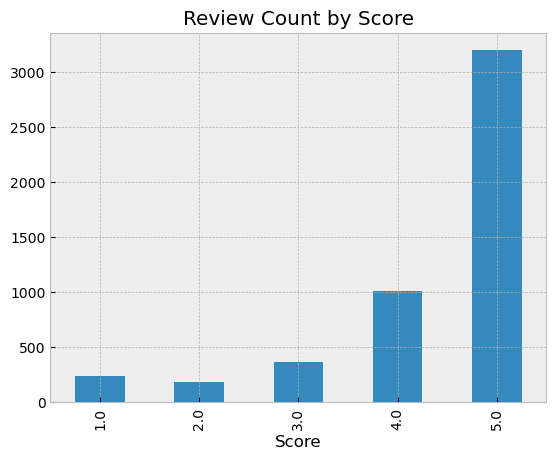

In [16]:
ax = df['score'].value_counts().sort_index() \
    .plot(kind='bar', 
          title='Review Count by Score')
ax.set_xlabel('Score')
plt.show()

<Axes: xlabel='Price', ylabel='score'>

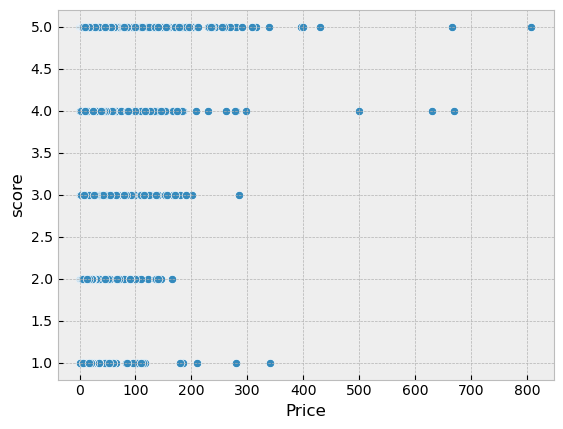

In [17]:
sns.scatterplot(x=df['Price'], y=df['score'])

<Axes: xlabel='Price'>

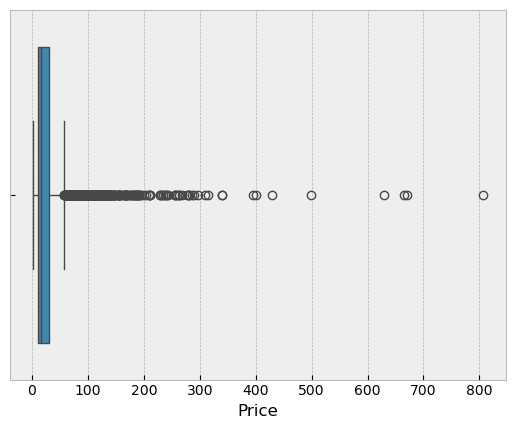

In [18]:
sns.boxplot(x=df['Price'])

<Axes: xlabel='review_date'>

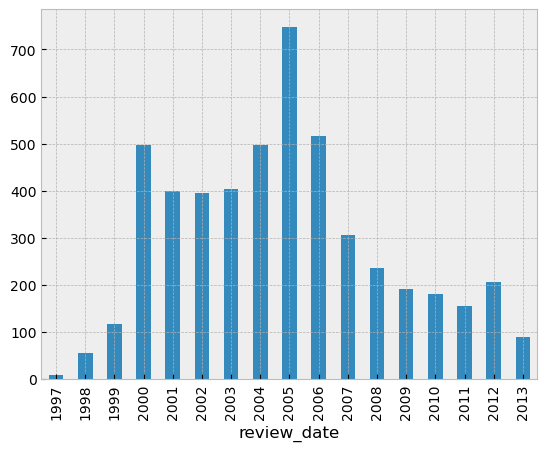

In [19]:
df['review_date'] = pd.to_datetime(df['review/time'], unit='s')


df['review_date'].dt.year.value_counts().sort_index().plot(kind='bar')

In [20]:
# For the purposes of this analysis, only the Id, Score, and Text will be needed
df = df[['Id', 'score', 'text']]

## Model Set-up

### Setting up VADERS

In [21]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [22]:
vader_analyzer = SentimentIntensityAnalyzer() 

### Setting up Roberta

In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [24]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest").to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Since some reviews exceed the maximum token length for roberta, long and short texts will be processed separately

In [33]:
def get_dict(scores):
    labels = ['neg', 'neu', 'pos']
    result = { 'roberta_neg': scores[0],
              'roberta_neu': scores[1],
              'roberta_pos': scores[2],
              'roberta_label': labels[np.argmax(scores)]
             }
    return result

In [30]:
def get_roberta_scores(text):
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs.input_ids
    if len(input_ids[0]) <= 512: 
        inputs = inputs.to(device)
        with torch.no_grad():
                model.eval()
                outputs = model(**inputs)
        logits = outputs.logits
        scores = F.softmax(logits, dim=1)
        scores = scores.cpu().numpy()[0]
        return get_dict(scores)
    else:
        return process_long_texts(text)


In [31]:
chunk_size = 512
def process_long_texts(text):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    input_ids = inputs['input_ids']

    num_chunks = int(np.ceil(len(input_ids[0]) / chunk_size)) 
    all_scores = []

    for i in range(num_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(input_ids[0]))
        chunk_input_ids = input_ids[:, start:end].to(device)

        with torch.no_grad():
            model.eval()
            chunk_outputs = model(input_ids=chunk_input_ids)
        chunk_logits = chunk_outputs.logits
        chunk_scores = F.softmax(chunk_logits, dim=1).cpu().numpy()[0]
        all_scores.append(chunk_scores)

    aggregated_scores = np.mean(all_scores, axis=0)
    
    return get_dict(aggregated_scores)

In [49]:
scores = {}
i = 0
vader_times = []
roberta_times = []
start = time()
for n, row in tqdm(df.iterrows(), total= len(df)):
    
    text = row['text']
    r_id = row['Id']
    
    vader_start = time()
    vader_scores = vader_analyzer.polarity_scores(text)
    vader_times.append(time() - vader_start)

    roberta_start = time()
    roberta_results = get_roberta_scores(text)
    roberta_times.append(time() - roberta_start)
    
    vader_results = {}
    for key, value in vader_scores.items():
        vader_results[f'vader_{key}'] = value
    compound = vader_scores['compound']
    if compound > 0.05:
        label = 'pos'
    elif compound > -0.05:
        label = 'neg'
    else:
        label = 'neu'
    vader_results['vader_label'] = label
        
    scores[r_id] = {**vader_results, **roberta_results}
total = time() - start

  0%|          | 0/5000 [00:00<?, ?it/s]

In [35]:
results_df = pd.DataFrame(scores).transpose()
results_df.head()

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,roberta_label
0829814000,0.012,0.888,0.101,0.8857,0.004158,0.070412,0.92543,pos
0595344550,0.062,0.771,0.167,0.9544,0.715185,0.244625,0.04019,neg
0253338352,0.0,0.937,0.063,0.9118,0.019172,0.83714,0.143688,neu
0802841899,0.012,0.859,0.129,0.9989,0.028092,0.62834,0.343567,neu
0918973031,0.044,0.809,0.147,0.875,0.007951,0.182764,0.809285,pos


In [36]:
results_df = results_df.reset_index().rename(columns = {'index' : 'Id'})
results_df = results_df.merge(df, how = 'left')
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,roberta_label,score,text
0,0829814000,0.012,0.888,0.101,0.8857,0.004158,0.070412,0.92543,pos,5.0,"I just finished the book, &quot;Wonderful Wors..."
1,0595344550,0.062,0.771,0.167,0.9544,0.715185,0.244625,0.04019,neg,1.0,I bought this book because I read some glowing...
2,0253338352,0.0,0.937,0.063,0.9118,0.019172,0.83714,0.143688,neu,5.0,from publisher:Addresses the interplay of dive...
3,0802841899,0.012,0.859,0.129,0.9989,0.028092,0.62834,0.343567,neu,5.0,With the publication of Everett Ferguson's boo...
4,0918973031,0.044,0.809,0.147,0.875,0.007951,0.182764,0.809285,pos,5.0,Although written with script authors et al in ...


## Reviewing Results:

In [37]:
print(f'Total time: {total}\n'
      f'Total Vaders: {np.sum(vader_times)}\n'
      f'Total Roberta: {np.sum(roberta_times)}\n'
      f'Average time per row:\n'
      f'   Vaders: {np.mean(vader_times)}\n'
      f'   Roberta: {np.mean(roberta_times)}')

Total time: 119.58158469200134
Total Vaders: 11.907102346420288
Total Roberta: 105.8945894241333
Average time per row:
   Vaders: 0.0023814204692840578
   Roberta: 0.021178917884826662


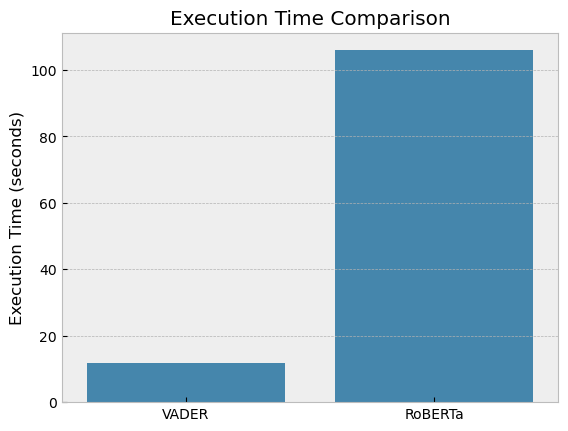

In [38]:
sns.barplot(x=['VADER', 'RoBERTa'], y=[np.sum(vader_times), np.sum(roberta_times)])
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison')
plt.show()

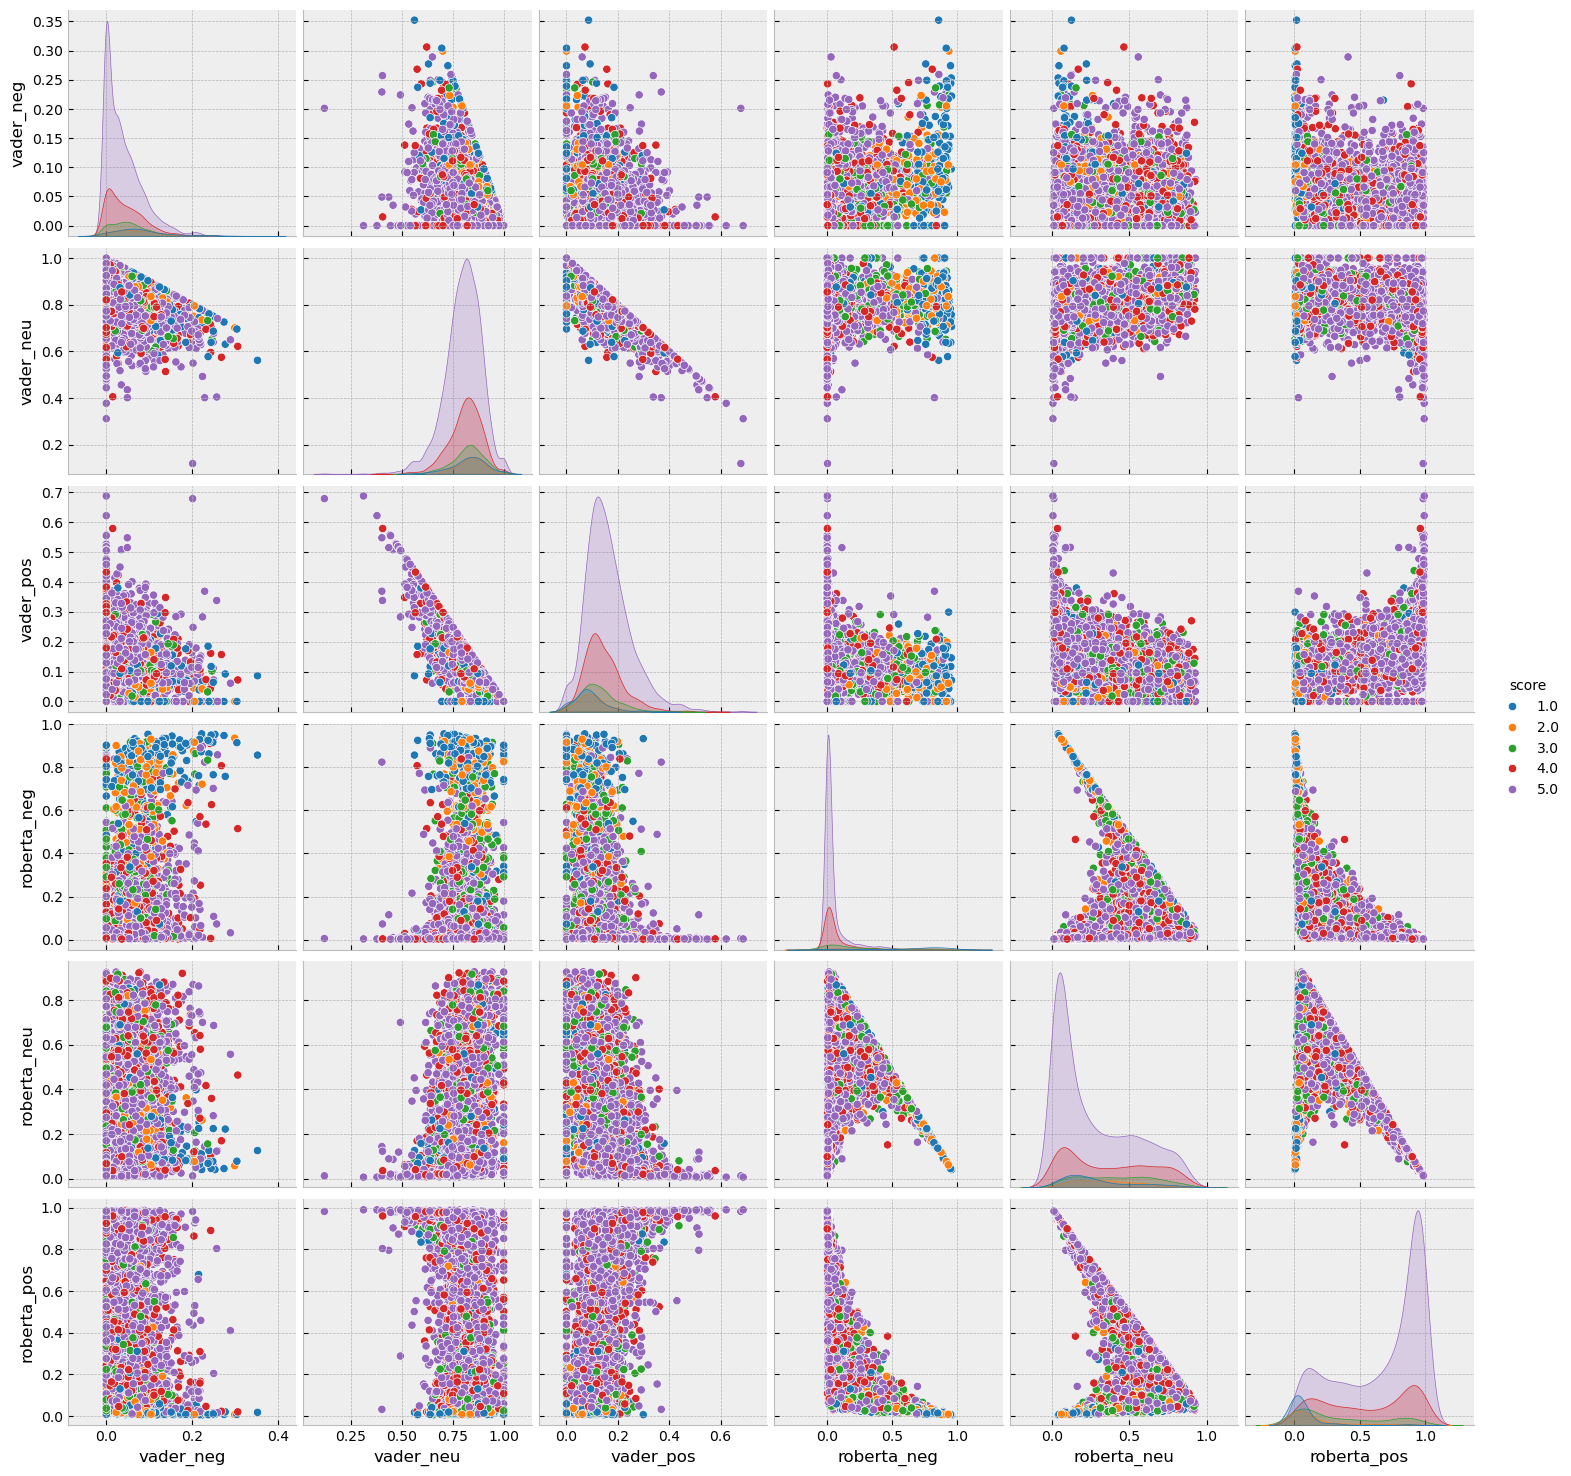

In [39]:
pair_plot = sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos', 
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='score',
            palette='tab10'
            )
plt.show()
pair_plot.savefig("out.png")

While the scatterplots in the correlation matrix present a dense visualization, the diagonal kernel density estimations reveal distinct distribution patterns between RoBERTa and VADER sentiment scores. RoBERTa demonstrates a higher degree of polarization, with negative and positive scores skewed towards extreme values, and neutral scores concentrated towards lower values. Conversely, VADER's distributions are less polarized, with positive scores also skewed towards lower values and neutral scores that are very widely distributed, highlighting a tendency to assign less extreme sentiment and a higher neutral score than RoBERTa.

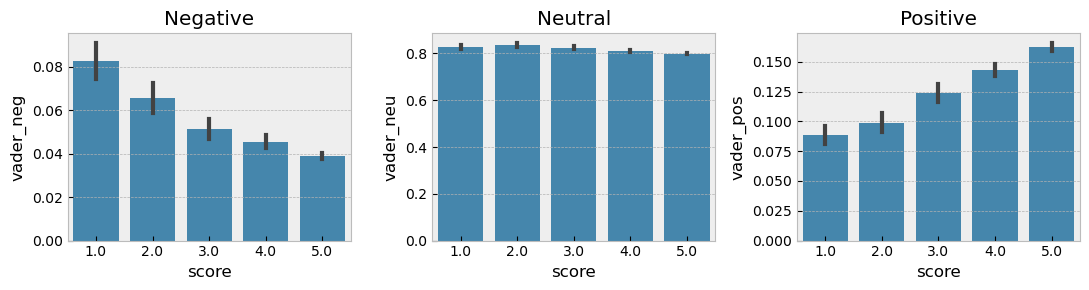

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11,3))
sns.barplot(data=results_df, x='score', y='vader_neg', ax=ax1)
sns.barplot(data=results_df, x='score', y='vader_neu', ax=ax2)
sns.barplot(data=results_df, x='score', y='vader_pos', ax=ax3)

ax1.set_title('Negative')
ax2.set_title('Neutral')
ax3.set_title('Positive')
plt.tight_layout()
plt.show()

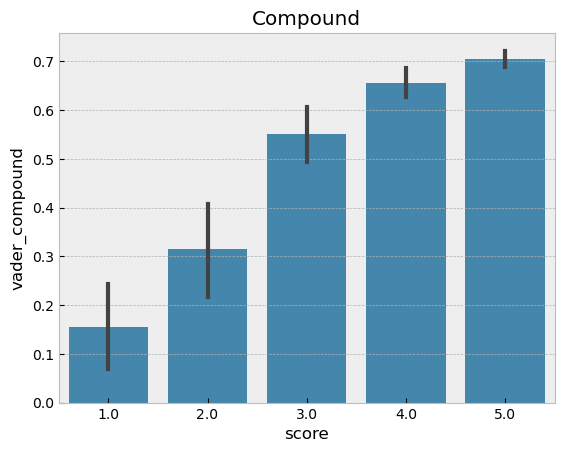

In [41]:
sns.barplot(data=results_df, x='score', y='vader_compound')
plt.title('Compound')
plt.show()

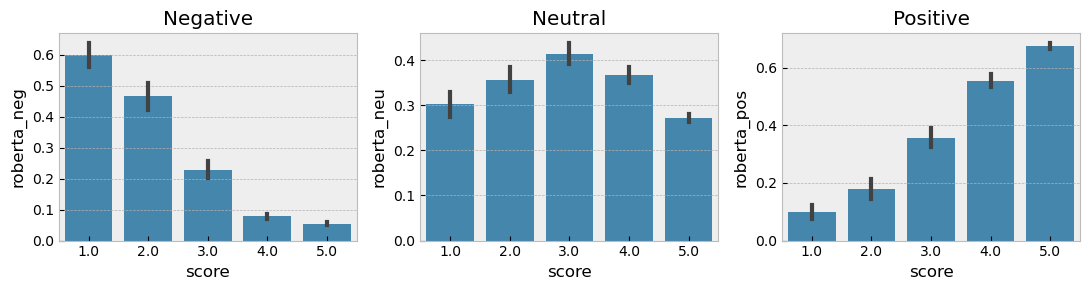

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11,3))
sns.barplot(data=results_df, x='score', y='roberta_neg', ax=ax1)
sns.barplot(data=results_df, x='score', y='roberta_neu', ax=ax2)
sns.barplot(data=results_df, x='score', y='roberta_pos', ax=ax3)
ax1.set_title('Negative')
ax2.set_title('Neutral')
ax3.set_title('Positive')
plt.tight_layout()
plt.show()

The VADER analysis revealed a subtle trend in negative and positive sentiment correlating with the score, but the scores were generally low and lacked polarization, suggesting uncertainty in its sentiment assignment. Notably, VADER showed a consistent neutral sentiment across all scores. In contrast, the RoBERTa model demonstrated a much clearer and more pronounced trend, with a wider range of sentiment scores, indicating higher sensitivity. Even the neutral sentiment from RoBERTa exhibited a discernible pattern, peaking at score 3, further highlighting its ability to capture nuanced sentiment variations compared to VADER

## Examples
### Choosing a random review:

In [43]:
df['text'].iloc[24]

'I am in love with the Little Critter books and so is my 3 year old son. This one in particular my son loved from the first page. He wanted to make his own peanut butter sandwich after reading it and I let him! He was so proud, just like Little Critter was with his PB and pickle sandwich. Great book.'

In [44]:
results_df.iloc[24]

Id                                                       0060539453
vader_neg                                                       0.0
vader_neu                                                     0.734
vader_pos                                                     0.266
vader_compound                                                0.965
roberta_neg                                                0.002767
roberta_neu                                                0.010243
roberta_pos                                                 0.98699
roberta_label                                                   pos
score                                                           4.0
text              I am in love with the Little Critter books and...
Name: 24, dtype: object

## Conflicting Sentiment and Review Scores

### Positve 1-Star Reviews

In [45]:
values = results_df.query('score == 1') \
    .sort_values('vader_pos', ascending=False)[['text', 'vader_pos']] \
    .values[0]
print(f'Rating: 1\n')
print(f'Review: {values[0]}\n')
print(f'Vader Positive Score: {values[1]}')

Rating: 1

Review: The main character, Arthur, decides to have a gymnastics contest at his birthday party. He announces to his friends that he will win the award for the best all-around gymnast, and repeatedly tells them that he is better at gymnastics than they are. Then he spends his party sulking because they can do gymnastics well also. His friends then decide to give him the award for best all-around gymnast.

Vader Positive Score: 0.38


In [46]:
values = results_df.query('score == 1') \
    .sort_values('roberta_pos', ascending=False)[['text', 'roberta_pos']] \
    .values[0]
print(f'Rating: 1\n')
print(f'Review: {values[0]}\n')
print(f'Roberta Positive Score: {values[1]}')

Rating: 1

Review: We got this for our son. He liked it a lot-so much so, he started imitated Elmo and became dependent on a blanket, which we were finally able to wean him off of. Keep that in mind!

Roberta Positive Score: 0.9606173038482666


### Negative 5-Star Reviews

In [47]:
values = results_df.query('score == 5') \
    .sort_values('vader_neg', ascending=False)[['text', 'vader_neg']] \
    .values[0]
print(f'Rating: 5\n')
print(f'Review: {values[0]}\n')
print(f'Vader Negative Score: {values[1]}')

Rating: 5

Review: Any college-level collection strong in social issues or women's issues will want to include the invaluable ENCYCLOPEDIA OF RAPE in their collection: it provides almost two hundred A-Z essays covering rape around the world, from basic concepts, offenders, and high-profile cases to social movements, legislative and legal efforts, and activists. From rape as an adjunct of wars to date rape and Catholic Church scandals, all the basics are covered along with statistics and bibliographic reference.

Vader Negative Score: 0.289


In [48]:
values = results_df.query('score == 5') \
    .sort_values('roberta_neg', ascending=False)[['text', 'roberta_neg']] \
    .values[0]
print(f'Rating: 5\n')
print(f'Review: {values[0]}\n')
print(f'Roberta Negative Score: {values[1]}')

Rating: 5

Review: So depressing. It's snowing again.....cold, melancholy......a suicide attempt that is a plan to end up in heaven as angels, turns into a disabled lifetime.

Roberta Negative Score: 0.9306409955024719
